Usando base de dados do [DATASUS TABNET](https://datasus.saude.gov.br/informacoes-de-saude-tabnet/) sobre [casos de Tuberculose](http://tabnet.datasus.gov.br/cgi/tabcgi.exe?sinannet/cnv/tubercbr.def).

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import time
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

In [3]:
url_tuberculose = 'https://raw.githubusercontent.com/LucasGabrielB/Alura-Bootcamp-Data-Science-Aplicada/main/Modulo-04/datasets/TUBERCULOSE%20-%20CASOS%20CONFIRMADOS%20NOTIFICADOS%20NO%20SISTEMA%20DE%20INFORMA%C3%87%C3%83O%20DE%20AGRAVOS%20DE%20NOTIFICA%C3%87%C3%83O%20-%20BRASIL.csv'

df_tuberculose = pd.read_csv(url_tuberculose, skiprows=3, skipfooter=17, sep=';', encoding='ISO-8859-1', engine='python')

df_tuberculose.head()

,Ano Diagnóstico,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627,87265
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809,92859
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303,93773
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196,92980
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541,92056


In [4]:
convert_months = {
    'Jan': 1,
    'Fev': 2,
    'Mar': 3,
    'Abr': 4,
    'Mai': 5,
    'Jun': 6,
    'Jul': 7,
    'Ago': 8,
    'Set': 9,
    'Out': 10,
    'Nov': 11,
    'Dez': 12,
}

In [5]:
# transformando o DataFrame em uma série temporal
df_tuberculose_ts = df_tuberculose.drop('Total', axis=1).melt(value_name='Casos', id_vars=['Ano Diagnóstico'], var_name='Mês')
df_tuberculose_ts['Data'] = df_tuberculose_ts.apply(lambda row: datetime(row['Ano Diagnóstico'], convert_months[row['Mês']], 1), axis=1)
df_tuberculose_ts.drop(['Ano Diagnóstico', 'Mês'], axis=1, inplace=True)
df_tuberculose_ts.sort_values('Data', inplace=True)
df_tuberculose_ts.index = df_tuberculose_ts['Data']
df_tuberculose_ts

,Casos,Data
Data,,
2001-01-01,8088,2001-01-01
2001-02-01,6542,2001-02-01
2001-03-01,8095,2001-03-01
2001-04-01,7305,2001-04-01
2001-05-01,7656,2001-05-01
...,...,...
2019-08-01,8239,2019-08-01
2019-09-01,8143,2019-09-01
2019-10-01,8592,2019-10-01


In [6]:
fig = go.Figure()

for year in range(2001, 2020):
    fig.add_trace(go.Scatter(name=str(year),
                            y=df_tuberculose_ts.query(f'Data.dt.year == {year}')['Casos'],
                            x=df_tuberculose_ts.query(f'Data.dt.year == {year}')['Data'].dt.month))

fig.update_traces(mode='markers+lines', hovertemplate=None)
fig.update_layout(
    hovermode='x',
    title={
        'text': 'Casos de Tuberculose ao longo dos anos no Brasil',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title='Número de casos',
    font={
        'family': 'Courier New, monospace',
        'size': 16
    },
    xaxis = {
        'tickmode': 'array',
        'tickvals':  list(convert_months.values()),
        'ticktext':  list(convert_months.keys())
    }
)

fig.show()

In [7]:
url_passengers = 'https://raw.githubusercontent.com/alura-cursos/serie_temporal_bootcamp/main/AirPassengers.csv'

df_passengers = pd.read_csv(url_passengers)
df_passengers['Month'] = pd.to_datetime(df_passengers['Month'])
df_passengers.rename({'Month': 'Date', '#Passengers': 'Passengers'}, axis=1, inplace=True)

df_passengers

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [8]:
px.line(data_frame=df_passengers,
        x='Date',
        y='Passengers',
        title='Numero de passageiros em voos de 1949 a 1960'
)

In [9]:
df_passengers['Month'] = df_passengers['Date'].dt.month
df_passengers['Year'] = df_passengers['Date'].dt.year

df_passengers.head()

,Date,Passengers,Month,Year
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949


In [10]:
train = df_tuberculose_ts.query('Data.dt.year != 2019')['Casos']
test = df_tuberculose_ts.query('Data.dt.year == 2019')['Casos']

arima_model = auto_arima(train, error_action='ignore', trace=True, max_p=1000, max_d=1000, max_q=1000, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3462.510, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3289.199, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3249.086, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3460.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3312.298, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3246.454, Time=1.97 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3398.593, Time=1.17 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3242.479, Time=2.38 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3246.995, Time=0.91 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3

In [11]:
prediction = arima_model.predict(12)
prediction

array([8159.98112671, 7481.16437183, 7963.33559255, 8121.14059974,
       7988.91051071, 7904.76381516, 8176.77704736, 8490.76305546,
       7925.54099216, 8480.63767896, 7961.66783448, 7587.81571076])

In [12]:
test

Data
2019-01-01    8392
2019-02-01    7754
2019-03-01    7648
2019-04-01    8274
2019-05-01    8383
2019-06-01    7363
2019-07-01    8382
2019-08-01    8239
2019-09-01    8143
2019-10-01    8592
2019-11-01    7615
2019-12-01    7220
Name: Casos, dtype: int64

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        y=test,
        name='Teste'
    )
)

fig.add_trace(go.Scatter(
        y=prediction,
        name='Previsão'
    )
)

fig.update_layout(
    title={'text': 'Previsão x Dados reais, para o numero de cassos de tuberculose em 2019.'}
)

fig.show()

In [14]:
mean_squared_error(test, prediction)

93378.93285752926

In [15]:
train_passengers = df_passengers.query('Year != 1960')['Passengers'].values
test_passengers = df_passengers.query('Year == 1960')['Passengers'].values

arima_model_passengers = auto_arima(train_passengers, error_action='ignore', trace=True, max_p=1000, max_d=1000, max_q=1000, seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.33 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.73 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.45 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [16]:
prediction_passengers = arima_model_passengers.predict(12)
prediction_passengers

array([419.967172  , 399.84985049, 457.99438118, 444.47415565,
       464.78917863, 514.12544051, 587.8041693 , 597.01082232,
       499.53126876, 442.35967856, 396.41021685, 438.65159514])

In [17]:
test_passengers

array([417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432])

In [18]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        y=test_passengers,
        name='Dados reais'
    )
)

fig.add_trace(go.Scatter(
        y=prediction_passengers,
        name='Previsão'
    )
)

fig.update_layout(
    title={'text': 'Previsão x Dados reais, para o numero de passageiros em 1960.'}
)

fig.show()

In [19]:
mean_squared_error(test_passengers, prediction_passengers)

343.6006816829735

In [20]:
from fbprophet import Prophet

In [21]:
df_train_passengers_prophet = df_passengers.query('Year != 1960')[['Date', 'Passengers']].rename({'Date': 'ds', 'Passengers': 'y'}, axis=1)
df_test_passengers_prophet = df_passengers.query('Year == 1960')[['Date', 'Passengers']].rename({'Date': 'ds', 'Passengers': 'y'}, axis=1)

prophet_model_passengers = Prophet(seasonality_mode='multiplicative').fit(df_train_passengers_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future_passengers = prophet_model_passengers.make_future_dataframe(periods=12, freq='M')
future_passengers

,ds
0,1949-01-01
1,1949-02-01
2,1949-03-01
3,1949-04-01
4,1949-05-01
...,...
139,1960-07-31
140,1960-08-31
141,1960-09-30
142,1960-10-31


In [23]:
prophet_passengers_prediction = prophet_model_passengers.predict(future_passengers)
prophet_passengers_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1949-01-01,115.603966,91.047746,116.949955,115.603966,115.603966,-0.101135,-0.101135,-0.101135,-0.101135,-0.101135,-0.101135,0.0,0.0,0.0,103.912403
1,1949-02-01,117.275019,86.467854,110.763452,117.275019,117.275019,-0.154216,-0.154216,-0.154216,-0.154216,-0.154216,-0.154216,0.0,0.0,0.0,99.189377
2,1949-03-01,118.784358,106.897260,132.337296,118.784358,118.784358,0.002721,0.002721,0.002721,0.002721,0.002721,0.002721,0.0,0.0,0.0,119.107520
3,1949-04-01,120.455412,104.757915,130.303245,120.455412,120.455412,-0.033256,-0.033256,-0.033256,-0.033256,-0.033256,-0.033256,0.0,0.0,0.0,116.449565
4,1949-05-01,122.072561,105.165975,130.523715,122.072561,122.072561,-0.027357,-0.027357,-0.027357,-0.027357,-0.027357,-0.027357,0.0,0.0,0.0,118.733027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-07-31,464.860836,572.588474,596.283042,464.197266,465.474385,0.257393,0.257393,0.257393,0.257393,0.257393,0.257393,0.0,0.0,0.0,584.512761
140,1960-08-31,467.660516,474.156154,499.829788,466.825881,468.449310,0.041049,0.041049,0.041049,0.041049,0.041049,0.041049,0.0,0.0,0.0,486.857711
141,1960-09-30,470.369885,414.310923,440.169697,469.341490,471.327494,-0.091353,-0.091353,-0.091353,-0.091353,-0.091353,-0.091353,0.0,0.0,0.0,427.400268
142,1960-10-31,473.169565,361.169866,386.491310,471.938759,474.285826,-0.210581,-0.210581,-0.210581,-0.210581,-0.210581,-0.210581,0.0,0.0,0.0,373.529040


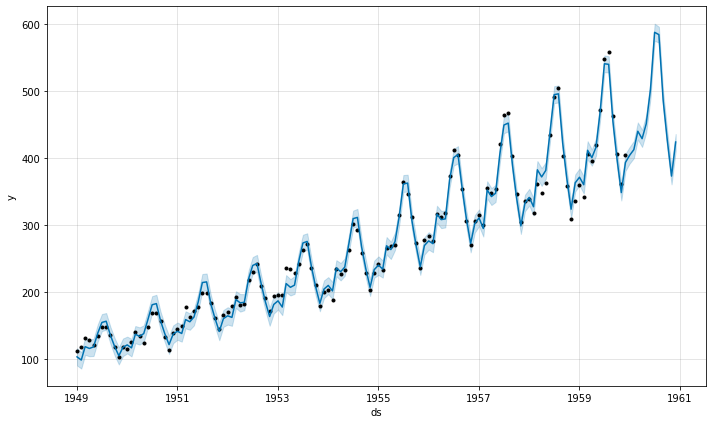

In [24]:
prophet_model_passengers.plot(prophet_passengers_prediction);

In [25]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        y=df_test_passengers_prophet['y'],
        name='Dados reais'
    )
)

fig.add_trace(go.Scatter(
        y=prophet_passengers_prediction[-12:]['yhat'],
        name='Previsão'
    )
)

fig.update_layout(
    title={'text': 'Previsão x Dados reais, para o numero de passageiros em 1960.'}
)

fig.show()